# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Consumer Price Index - Germany
#### 6. ARIMA Bonus

### 1. Importing your libraries and data

In [44]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear.

In [45]:
# Configure API key 

quandl.ApiConfig.api_key = 'zF-mkbD********'

In [46]:
# Importing the Consumer Price Index - Germany.

data = quandl.get('RATEINF/CPI_DEU')

In [47]:
data.head(5)

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [48]:
data.shape

(371, 1)

In [49]:
data.columns

Index(['Value'], dtype='object')

In [50]:
type(data)

pandas.core.frame.DataFrame

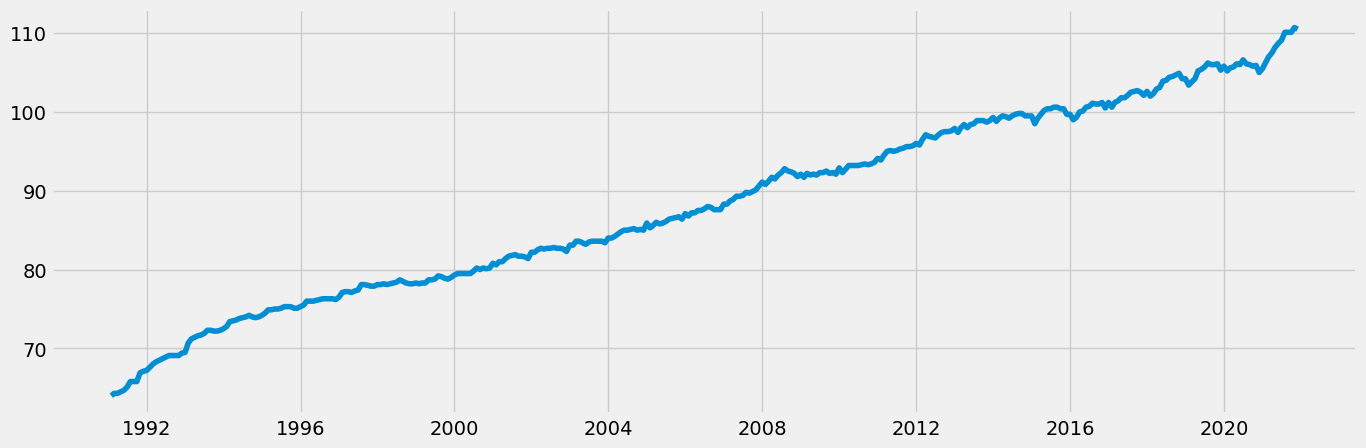

In [51]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [52]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [53]:
data_2.head()

,Date,Value
0,1991-01-31,64.0
1,1991-02-28,64.3
2,1991-03-31,64.3
3,1991-04-30,64.5
4,1991-05-31,64.7


In [54]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-10-08')]

- I used until 2019-10-08 for the end date as my Apartment rental offers in Germany dataset is from this date. This would allow me to make some connection to my project



In [55]:
data_sub.shape

(357, 2)

In [56]:
data_sub.head()

,Date,Value
0,1991-01-31,64.0
1,1991-02-28,64.3
2,1991-03-31,64.3
3,1991-04-30,64.5
4,1991-05-31,64.7


In [57]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


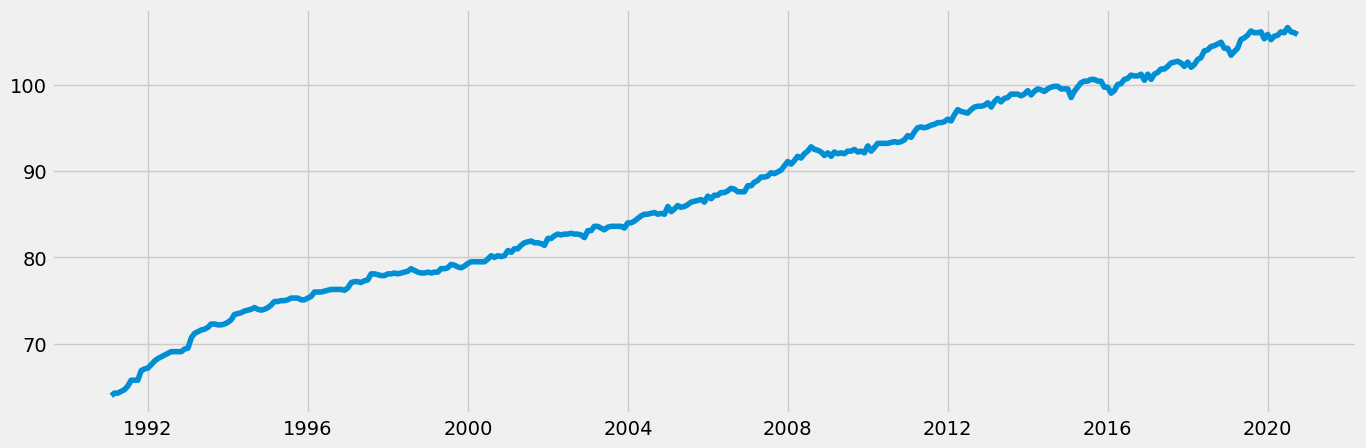

In [58]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [59]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [62]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

143

In [63]:
data_sub.drop_duplicates()


,Value
datetime,
1991-01-31,64.0
1991-02-28,64.3
1991-04-30,64.5
1991-05-31,64.7
1991-06-30,65.1
...,...
2019-10-31,106.1
2019-11-30,105.3
2019-12-31,105.8


### 3. Time-series analysis: decomposition

In [64]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [65]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

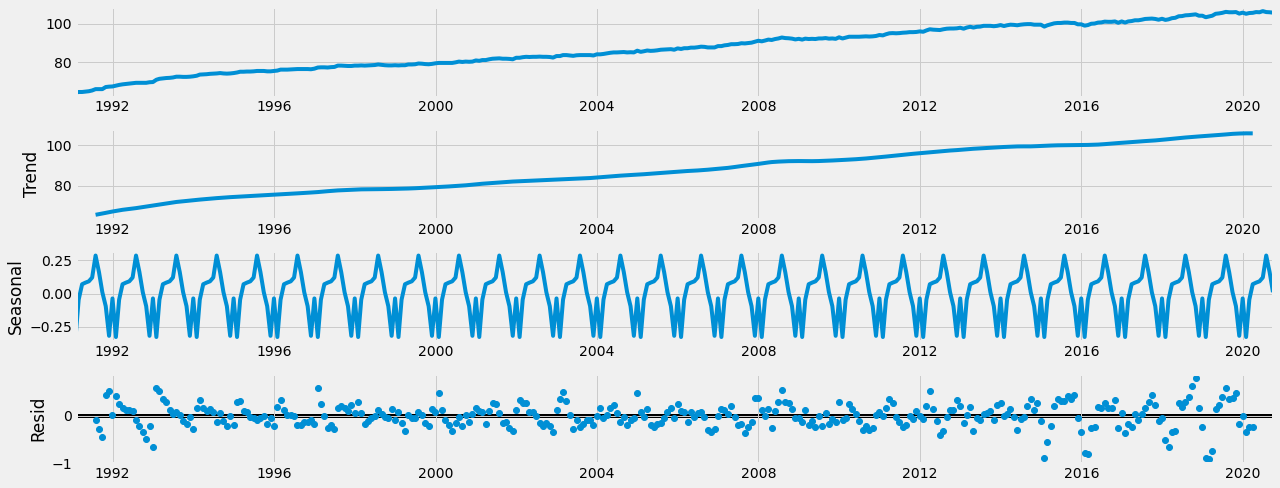

In [66]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [67]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.930364
p-value                          0.777809
Number of Lags Used             14.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


The test statistic is larger than the critical values, so can't reject the null hypotheis. Furthermore, the p-value is also not significant as it has a value greater than 0.05. This means that there is a unit root in the data, and the data is non-stationary

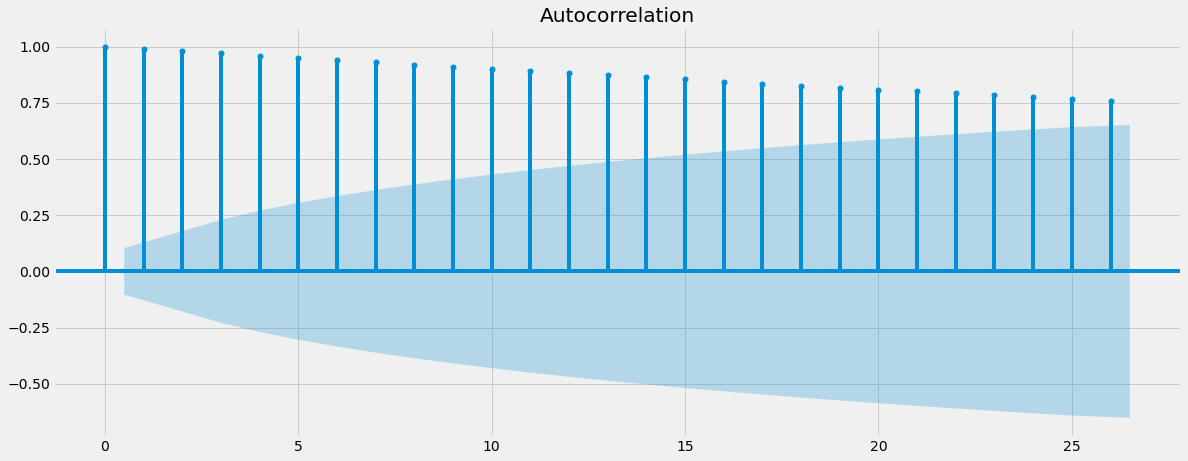

In [68]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

- All the lines go above the blue edge of the confidence interval, which means that we have lags that are significantly correlated with each other.
- we can deduce that the data is non-stationary  which supports the result of the Dickey-Fuller test

### 5. Stationarizing the Consumer Price Index - Germany

In [69]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [70]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [71]:
data_diff.head()

,Value
datetime,
1991-02-28,0.3
1991-03-31,0.0
1991-04-30,0.2
1991-05-31,0.2
1991-06-30,0.4


In [72]:
data_diff.columns

Index(['Value'], dtype='object')

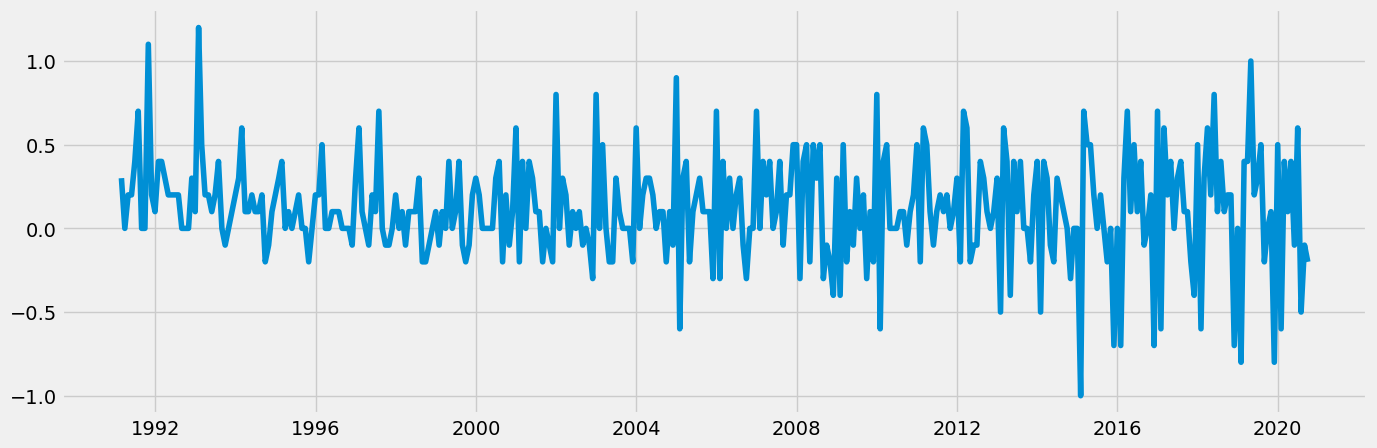

In [73]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [74]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.169393
p-value                          0.000742
Number of Lags Used             13.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


- Test statistic is smaller than critical value, so wecan reject null hypothesis
- p value is also significant with a value less than 0.05
- So there is no unit root and data is stationary

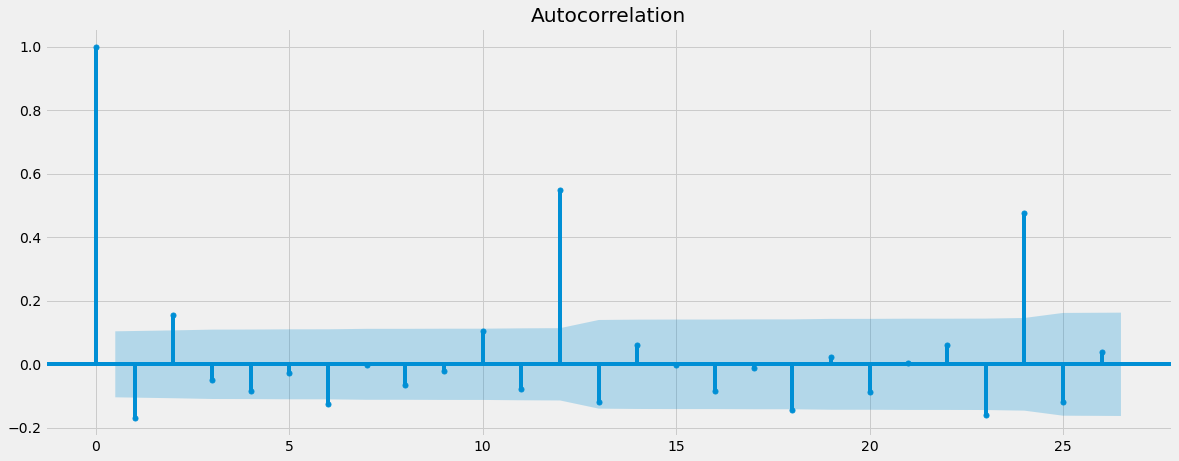

In [75]:
plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that your data is stationary, that stationarity is weak. 

## 6. ARIMA Bonus

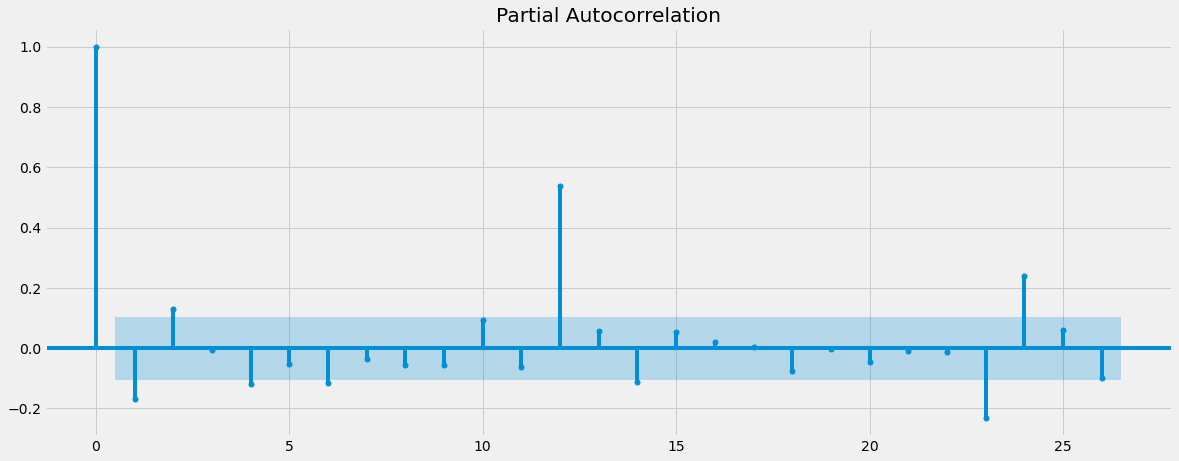

<Figure size 4500x4500 with 0 Axes>

In [76]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

In the figure above, there are some highly positive bars. These indicate significant correlations

- This call for an ARIMA model

- As we only difference once , d = 1 
- AR seems to be 0, so p = 0 ?

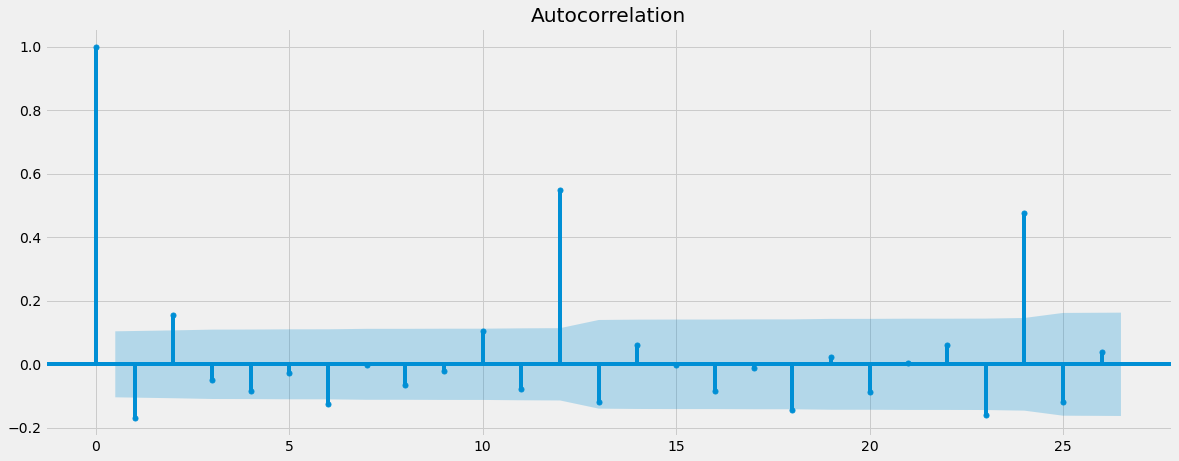

<Figure size 1500x500 with 0 Axes>

In [77]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

q is likely to be 1

In [78]:
# Split the data

train = data_diff['Value'][:121]
test = data_diff['Value'][120:]

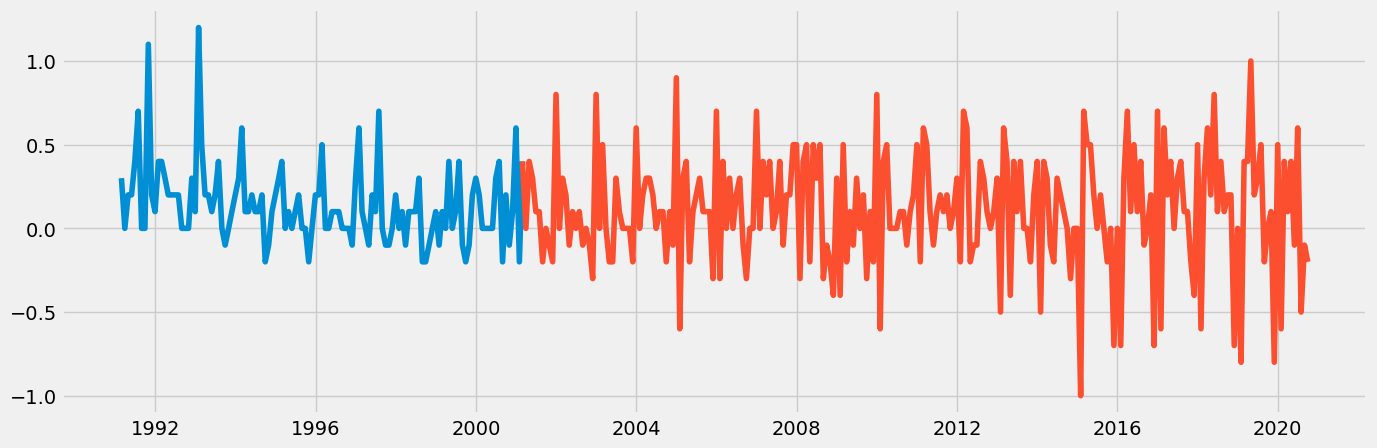

In [79]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [80]:
test.shape

(236,)

In [81]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  120
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   5.908
Method:                       css-mle   S.D. of innovations              0.226
Date:                Sun, 12 Dec 2021   AIC                             -5.817
Time:                        22:58:29   BIC                              2.546
Sample:                    03-31-1991   HQIC                            -2.421
                         - 02-28-2001                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0018      0.001     -3.049      0.002      -0.003      -0.001
ma.L1.D.Value    -1.0000      0.036    -27.408      0.000      -1.072      -0.928
                                    Root

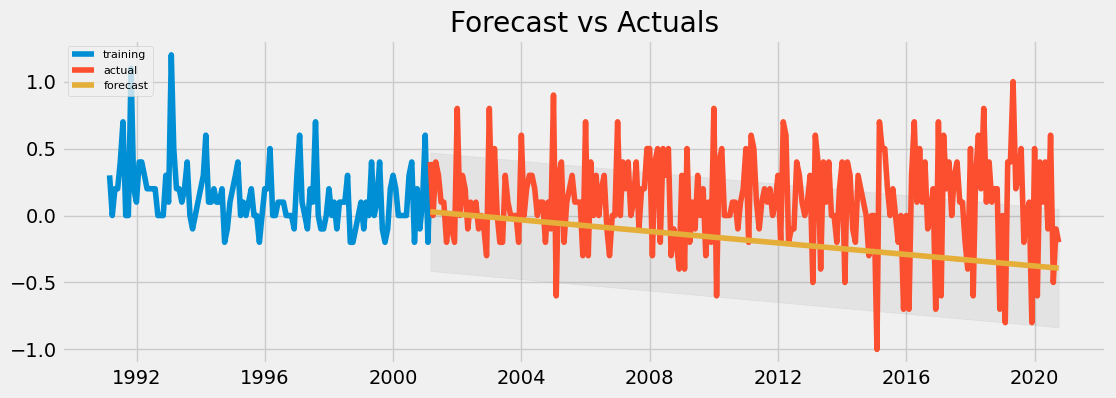

In [88]:
model = ARIMA(train, order=(0, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(236, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 41 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
lower_series = pd.Series(conf[:, 0], index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   6.190
Method:                       css-mle   S.D. of innovations              0.225
Date:                Sun, 12 Dec 2021   AIC                             -4.380
Time:                        22:58:56   BIC                              6.770
Sample:                    03-31-1991   HQIC                             0.148
                         - 02-28-2001                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0018      0.001     -2.832      0.005      -0.003      -0.001
ar.L1.D.Value     0.0693      0.092      0.751      0.453      -0.112       0.250
ma.L1.D.Value    -0.9999      0.033    -

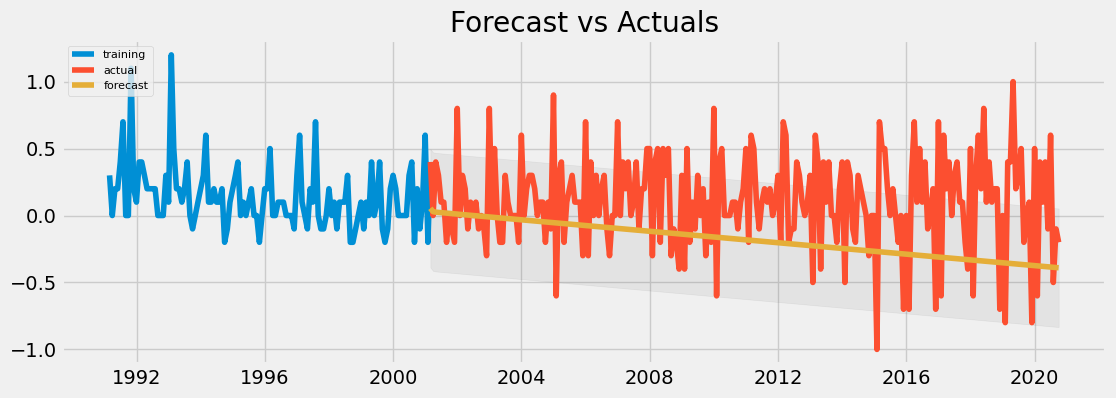

In [89]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(236, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

- The model is not perfect but it is within the confidence interval